# Pretty color images of the line maps


In [80]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
from astropy.visualization import make_lupton_rgb
from astropy.visualization.lupton_rgb import LinearMapping
from astropy.io import fits
from astropy.wcs import WCS
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve, convolve_fft
import seaborn as sns
from mpdaf.obj import Image
import regions
import sys
import pandas as pd
import cmasher as cmr
import pyneb as pn
sys.path.append("../lib")
from wcsfile import wcsfile

sns.set_context("talk")
sns.set_color_codes()

We want to read in the images that I have saved from the MUSE datacube.  But, the WCS need to be corrected to the Gaia frame.  For that, we use the simple header file that I have written. 

In [58]:
datadir = Path("../data")
HDU = "DATA"
def load_and_scale_image(fn, v1, v2, ihdu=HDU):
    data = fits.open(datadir / f"ngc346-{fn}.fits")[ihdu].data
    return (data - v1) / (v2 - v1)


def make_rgb_wcs(chandata):
    chan_images = []
    for chanid, v1, v2 in chandata:
        chan_images.append(load_and_scale_image(chanid, v1, v2))
    w = WCS(wcsfile.read(datadir / "ngc346-muse-deep-2d-gaia.wcs"))
#    w = WCS(fits.open(datadir / f"ngc346-{chanid}.fits")[HDU].header)
    return chan_images, w

STRETCH = 0.9
Q = 2.5

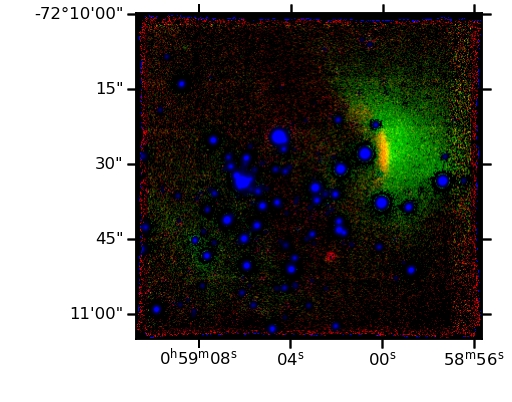

In [106]:
chandata = [
    ["heii-4686-correct", 0.0, 350.0],
    ["ariv-4711-plus-4740-correct", 0.0, 700.0],
    ["cont-4686-mean", 0.0, 1e4],
]
[r, g, b], w = make_rgb_wcs(chandata)
#image = make_lupton_rgb(r, g, b, stretch=STRETCH, Q=Q)
image = LinearMapping(0.0, 1.0).make_rgb_image(r, g, b)
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(projection=w.celestial))
ax.imshow(image)
ax.set(
    xlabel=" ",
    ylabel=" ",
)
fig.savefig("../figs/ngc-346-bow-multi-muse-high-ion.pdf");

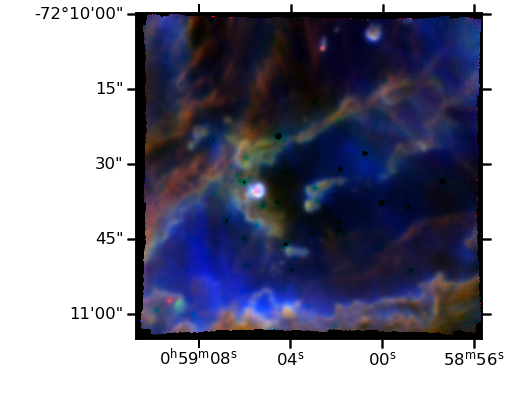

In [107]:
chandata = [
    ["oi-6300-bin01-sum", 0.0, 1500.0],
    ["sii-6731-bin01-sum", 0.0, 7000.0],
    ["siii-9069-bin01-sum", 0.0, 6e3],
]
[r, g, b], wm = make_rgb_wcs(chandata)
image = make_lupton_rgb(r, g, b, stretch=STRETCH, Q=Q)
#image = LinearMapping(0.0, 1.0).make_rgb_image(r, g, b)
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(projection=wm))
ax.imshow(image)
ax.set(
    xlabel=" ",
    ylabel=" ",
)
fig.savefig("../figs/ngc-346-bow-multi-muse-low-ion.pdf");

In [53]:
list(datadir.glob("*.wcs"))

[PosixPath('../data/ngc346-muse-deep-3d-gaia.wcs'),
 PosixPath('../data/ngc346-ha-plus-wings-cube-gaia.wcs'),
 PosixPath('../data/ngc346-muse-23.882-3d-gaia.wcs'),
 PosixPath('../data/ngc346-muse-deep-2d-gaia.wcs'),
 PosixPath('../data/ngc346-muse-23.882-2d-gaia.wcs')]

In [57]:
w = WCS(wcsfile.read(datadir / "ngc346-muse-deep-2d-gaia.wcs"))
w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 14.7839838  -72.1792558  
CRPIX : 59.354325  99.019415  
CD1_1 CD1_2  : -5.5555555555555e-05  0.0  
CD2_1 CD2_2  : 0.0  5.55555555555556e-05  
NAXIS : 0  0

In [65]:
hduacs = fits.open("../big-data/ngc346-hst-acs-f658n-wcsgaia.fits")["SCI"]
wacs = WCS(hduacs.header)

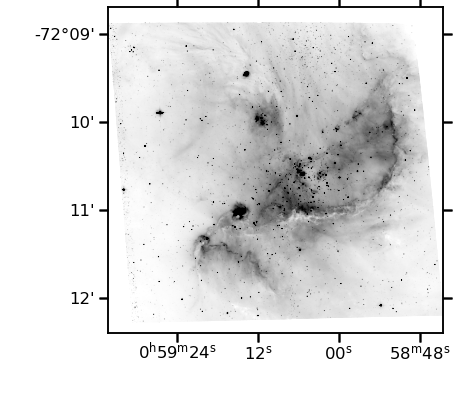

In [105]:
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(projection=wacs))
ax.imshow(hduacs.data, cmap="gray_r", vmin=0.05, vmax=0.9)
ax.set(
    xlabel=" ",
    ylabel=" ",
)
fig.savefig("../figs/ngc-346-bow-multi-acs-wide.pdf");

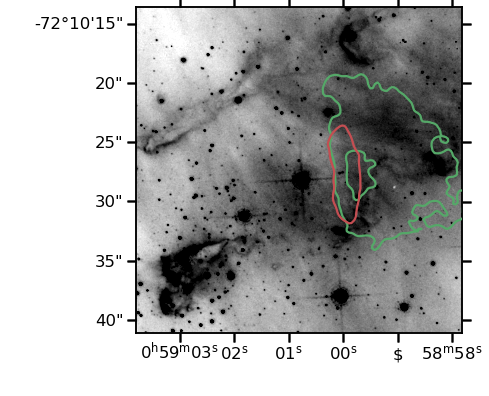

In [108]:
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(projection=wacs))
ax.imshow(hduacs.data, cmap="gray_r", vmin=0.25, vmax=0.6)
gauss = Gaussian2DKernel(x_stddev=1.5)
imariv = fits.open(datadir / f"ngc346-ariv-4711-plus-4740-correct.fits")["DATA"].data
imariv_s = convolve(imariv, gauss)
imheii = fits.open(datadir / f"ngc346-heii-4686-correct.fits")["DATA"].data
imheii_s = convolve(imheii, gauss)
ax.contour(
    imariv_s, 
    transform=ax.get_transform(wm),
    levels=[350, 560], 
    colors="g",
)
ax.contour(
    imheii_s, 
    transform=ax.get_transform(wm),
    levels=[150], 
    colors="r",
)
ax.set(
    xlim=[2800, 3350],
    ylim=[2050, 2600],
    xlabel=" ",
    ylabel=" ",
)
fig.savefig("../figs/ngc-346-bow-multi-acs-zoom.pdf");